## WS25: Seminar: Business Analytics (Master) - BWL 12
### Topic: Supply Chain Resilience under Disruptions — An Agent-Based Simulation with Mesa

In [14]:
from model import MultiTierModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [15]:
# ---------------------------
# Assumptions & strategies
# ---------------------------
assumptions = {
    "n_suppliers": 2,
    "n_plants": 1,
    "n_dcs": 1,
    "n_retailers": 3,
    "base_stock": {"supplier": 70, "plant": 60, "dc": 50, "retailer": 30},
    "capacity": {"supplier": 20, "plant": 15, "dc": 10, "retailer": 0},
    "lead_time": {"supplier": 1, "plant": 5, "dc": 5, "retailer": 3},
    "capacity_loss_frac": 0.1,
    "recovery_duration": 2,
    "holding_cost": 1.0,
    "backlog_cost": 5.0,
    "retailer_demand_mean": 5.0
}

n_steps = 60
scenarios = ["capacity_loss", "lead_time_surge", "demand_spike"]

strategy_configs = {
    "baseline": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": False},
    "dual_only": {"dual_sourcing": True, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": False},
    "safety_only": {"dual_sourcing": False, "safety_stock_factor": 1.2, "flexible_capacity": False, "dynamic_reallocation": False},
    "flex_only": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": True, "dynamic_reallocation": False},
    "dynalloc_only": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": True}
}

results = {}

# run experiments
for scenario in scenarios:
    print(f"\n=== Scenario: {scenario} ===")
    for sname, sconf in strategy_configs.items():
        print(f" Running strategy: {sname}")
        model = MultiTierModel(assumptions=assumptions, seed=SEED,
                               strategies=sconf, disruption_at_step=10, scenario=scenario)
        fill_rates = []
        total_costs = []
        for t in range(n_steps):
            model.step()
            fill_rates.append(model.compute_fill_rate())
            total_costs.append(model.compute_total_cost())
        df = pd.DataFrame({"step": range(n_steps), "fill_rate": fill_rates, "total_cost": total_costs})
        bullwhip = model.compute_bullwhip()
        backlog_duration = model.compute_backlog_duration()
        ttr = model.compute_time_to_recover(target_frac=0.95)
        results[(scenario, sname)] = {"df": df, "bullwhip": bullwhip, "backlog_duration": backlog_duration, "ttr": ttr}
        print(f"  Final fill: {fill_rates[-1]:.3f} | total_cost: {total_costs[-1]:.1f} | bullwhip: {bullwhip:.3f} | backlog_dur: {backlog_duration:.1f} | TTR: {ttr}")



=== Scenario: capacity_loss ===
 Running strategy: baseline
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:70 Bk:0 Pipe:0>
  Final fill: 0.625 | total_cost: 52973.0 | bullwhip: 0.000 | backlog_dur: 52.0 | TTR: nan
 Running strategy: dual_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 2 plant Inv:60 Bk:0 Pipe:0>
  Final fill: 0.625 | total_cost: 52973.0 | bullwhip: 0.000 | backlog_dur: 52.0 | TTR: nan
 Running strategy: safety_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:84 Bk:0 Pipe:0>
  Final fill: 0.749 | total_cost: 38739.0 | bullwhip: 0.000 | backlog_dur: 44.3 | TTR: nan
 Running strategy: flex_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:84 Bk:0 Pipe:0>
  Final fill: 0.749 | total_cost: 38748.0 | bullwhip: 0.000 | backlog_dur: 44.3 | TTR: nan
 Running strategy: dynalloc_only
[Disruption] t=10 scenario=capacity_loss victim=<Firm 0 supplier Inv:84 Bk:0 Pipe:0>
  Final fill: 0.771 | total_cos

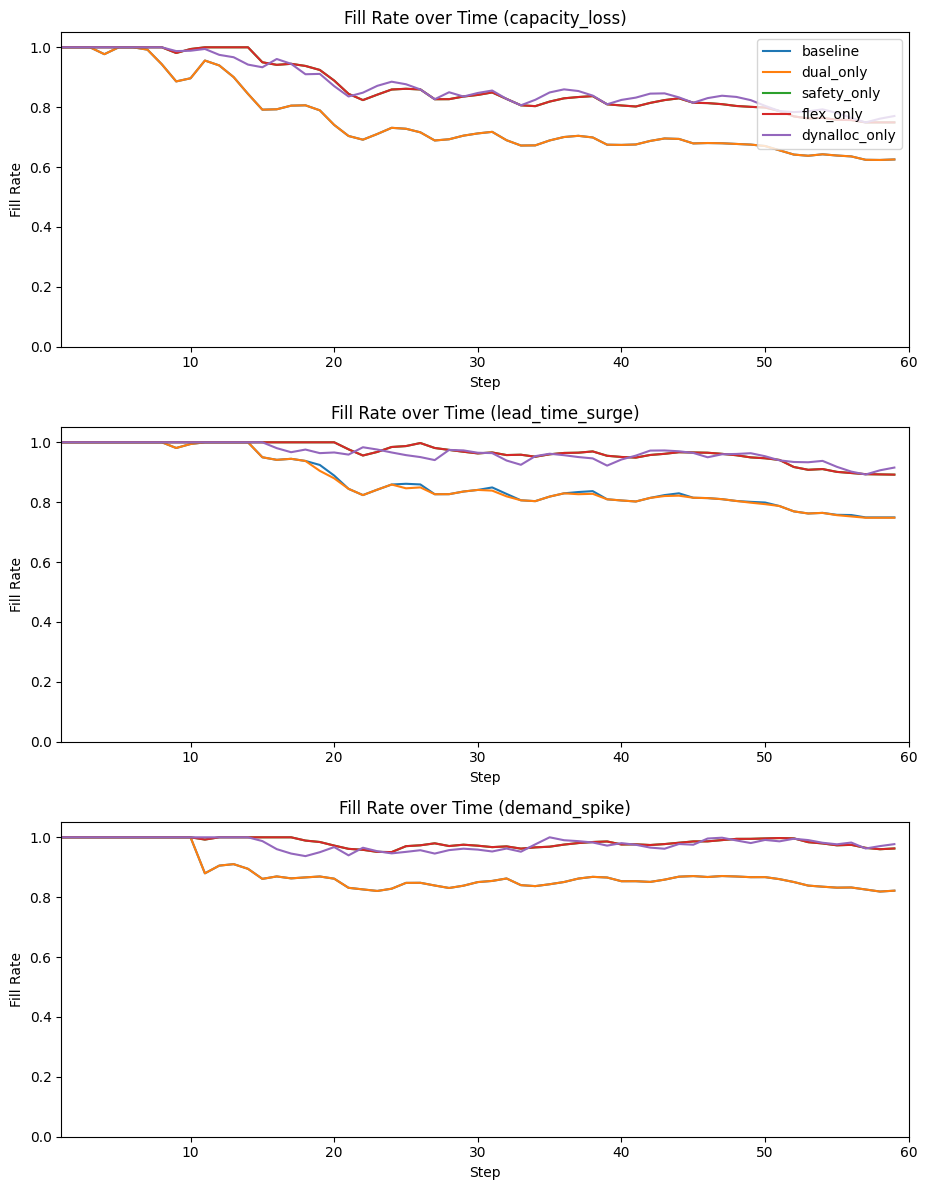

/tmp/ipykernel_108608/1862386412.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(color_scenario, subset=["Scenario"]).set_caption("Summary of All Scenarios and Strategies (Colored by Scenario)")


,Scenario,Strategy,Final Fill Rate,Total Cost,Bullwhip,Backlog Duration,Time to Recover
4,capacity_loss,dynalloc_only,0.77,37195.0,0.00,42.7,nan
2,capacity_loss,safety_only,0.75,38739.0,0.00,44.3,nan
3,capacity_loss,flex_only,0.75,38748.0,0.00,44.3,nan
0,capacity_loss,baseline,0.63,52973.0,0.00,52.0,nan
1,capacity_loss,dual_only,0.63,52973.0,0.00,52.0,nan
14,demand_spike,dynalloc_only,0.98,26888.0,0.01,19.3,nan
12,demand_spike,safety_only,0.96,25707.0,0.00,20.3,nan
13,demand_spike,flex_only,0.96,25722.0,0.00,20.3,nan
10,demand_spike,baseline,0.82,40091.0,0.00,49.0,nan
11,demand_spike,dual_only,0.82,40091.0,0.00,49.0,nan


In [16]:
plt.figure(figsize=(18, 12))

for i, scenario in enumerate(scenarios, 1):
# Fill rate subplot
    plt.subplot(3, 2, 2*i - 1)
    for sname in strategy_configs:
        df = results[(scenario, sname)]["df"]
        plt.plot(df["step"], df["fill_rate"], label=sname)
        plt.title(f"Fill Rate over Time ({scenario})")
        plt.xlabel("Step")
        plt.ylabel("Fill Rate")
        plt.ylim(0, 1.05)
        plt.xlim(1, 60)
        if i == 1:
            plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

#summary table 
rows = []
for scenario in scenarios:
    for sname in strategy_configs:
        out = results[(scenario, sname)]
        rows.append({
            "Scenario": scenario,
            "Strategy": sname,
            "Final Fill Rate": out["df"]["fill_rate"].iloc[-1],
            "Total Cost": out["df"]["total_cost"].iloc[-1],
            "Bullwhip": out["bullwhip"],
            "Backlog Duration": out["backlog_duration"],
            "Time to Recover": out["ttr"]
            })

summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(["Scenario", "Final Fill Rate"], ascending=[True, False])

scenario_colors = {
"capacity_loss": "#FF0000", 
"lead_time_surge": "#EEFF00",
"demand_spike": "#00AEFF"
}

def color_scenario(val):
    return f"background-color: {scenario_colors.get(val, '')}"

styled_summary = summary_df.style.format({
"Final Fill Rate": "{:.2f}",
"Total Cost": "{:.1f}",
"Bullwhip": "{:.2f}",
"Backlog Duration": "{:.1f}",
"Time to Recover": "{:.1f}"
}).applymap(color_scenario, subset=["Scenario"]).set_caption("Summary of All Scenarios and Strategies (Colored by Scenario)")

styled_summary